This notebook intends to give a walkthrough on how one can process the raw data collected by a SWACS scan.

In [1]:
import h5py
import hdf5plugin
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 1. Analyze .h5 data  
We start our exploration by loading the desired file, in this case `scan-0035.h5`, and look what groups the data file contains. This is what is referred to as the master file in the measurement. I'm not really sure what that means.
 
The top level group is called `entry` which in turn contains some groups and datasets.  
The file contains a bunch of data that I don't understand what it is. One can explore it further by examining the group hierarchies (which work like dictionaries) and datasets (that work like Numpy arrays). We will focus on the data contained in `entry/title` and `entry/instrument/albaem-e01_ch1/data`. In order to work with the data in a reasonable manner we save `entry/title` to a dictionary `metadata` and keep the intensity data`entry/instrument/albaem-e01_ch1/data` as a Numpy array.

In [2]:
file_path = os.getcwd().replace('chalmers', 'data/scan-0035.h5')
print("Reading file: {}".format(file_path))
with h5py.File(file_path, 'r') as fh:
    print("The .h5 data contains top level key: {}".format(list(fh.keys())))
    print("Under the 'entry' key we find the keys: {}".format(list(fh['entry'].keys())))
    print("Measurement content: {}".format(list(fh['entry']['measurement'].keys())))
    #data = fh['entry']['instrument']['albaem-e01_ch1']['data']

Reading file: /home/holger/PROJ/MVE386/data/scan-0035.h5
The .h5 data contains top level key: ['entry']
Under the 'entry' key we find the keys: ['end_time', 'instrument', 'measurement', 'start_time', 'title']
Measurement content: ['albaem-e01_ch1', 'albaem-e01_ti', 'eiger', 'lambda', 'pandapcap_tomo_ry', 'pcap_fast_axis', 'pcap_ts_trig', 'sc_swaxs_yh', 'swaxs_x']


Now lets move on to the `scan-0035_lambda.h5` file that contains the data measured using the lambda detector. This detector is used to capture the WAXS data. In this part we simply use the code from `swaxs_analysis3.ipynb` to plot the raw WAXS data.

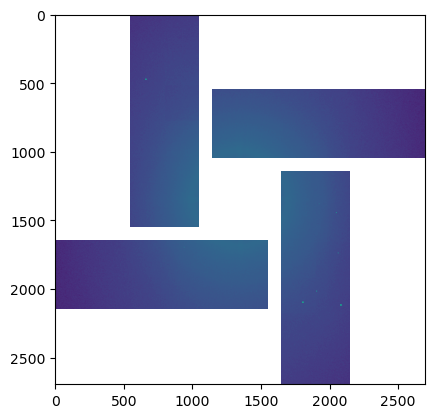

In [3]:
image_to_plot = 1
file_path = os.getcwd().replace('chalmers', 'data/scan-0035_lambda.h5')
with h5py.File(file_path, 'r') as fh:
    full_shape = fh['/entry/instrument/lambda/full_shape'][()]
    rotation = fh['/entry/instrument/lambda/rotation'][()]
    x = fh['/entry/instrument/lambda/x'][()]
    y = fh['/entry/instrument/lambda/y'][()]
    data = fh['/entry/instrument/lambda/data'][image_to_plot, :, :, :]
fulldata = np.empty(full_shape)
fulldata[:] = np.nan
for i in range(4):
    rotdata = np.rot90(data[i, :, :], -rotation[i] / 90)  # rotate each detector
    fulldata[y[i]:y[i] + rotdata.shape[0], x[i]:x[i] + rotdata.shape[1]] = rotdata
plt.imshow(fulldata, norm="log")
fulldata = None
rotdata = None

Along with the raw data files, MaxIV is also supplying integrated data which is easier to work with. We go on loading one of those files. We load the lambda detector data which is the WAXS data. 

Here we just copy supplied code from MaxIV to load the data.

In [4]:
"""
keys in file that will be loaded
    **FROM AZINT FILE**
    'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
    'azi', : azimuthal bins
    'mask_file', : file path for mask used for radial integration
    'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
    'polarization_factor', : polarisation factor used for integration
    'poni_file', : file path for pony file
    'q', : q Vektor for integration
    **FROM MASTER FILE**
    'i_t', : diode data, transmittance for 2D map
    'dt' : exposure time from eiger/lambda/diode
    'title' :  scan command from SPOCK
    'swaxs_x' : swaxs_x stage position (encoder reading)
    'swaxs_y' : swaxs_y stage position (theoretical reading)
    'swaxs_rot' : swaxs_y stage position (theoretical reading)
    'time' : time point for triggers for exposure
"""

file_path = os.getcwd().replace('chalmers', 'data/scan-0035_lambda_integrated.h5')

data = {}
items = {
    'I': 'entry/data2d/cake',
    'q': 'entry/data1d/q',
    'azi': 'entry/data2d/azi',
    'mask_file': 'entry/azint/input/mask_file',
    'norm': 'entry/data2d/norm',
    'polarization_factor': 'entry/azint/input/polarization_factor',
    'poni': 'entry/azint/input/poni',
}
with h5py.File(file_path, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            data[key] = fh[name][()]

master = file_path.replace('_lambda_integrated', '')
items = {
    'i_t': 'entry/instrument/albaem-e01_ch1/data',
    'title': 'entry/title'
}
with h5py.File(master, 'r') as fh:
    for key, name in items.items():
        if name in fh:
            data[key] = fh[name][()]

data['shape'] = (int((str(data['title']).split(' '))[8]) + 1, int((str(data['title']).split(' '))[4]))


Now lets examine the loaded data. 

We see that the array 'I' has shape (3050, 180, 2000). This means that this measurement contains 3050 images, 180 azimuthals and 2000 q values.
An image is one x-ray scan at a given point. Then the next scan is performed at a small displacement next to the previous.
The azimuthals are the angle of the measurements ranging from 1.0 to 359.0, $\xi \in [1, 359]$.
The q values are defined as in eq. (2.6) in (Björn, 2018) $\vert \overrightarrow{q} \vert = q = \frac{4 \pi}{\lambda} \sin \frac{\theta}{2}$. 

To further understand the data we can look at figures 2.13 and 3.6 in (Björn, 2018). 

In figure 2.13 we see how *ONE* image is produced. $\overrightarrow{q}$ is a vector that we norm using the above formula.
![Figure 2.13 (Björn, 2018)](images/fig2-13_bjorn_2018.png)

Now for every image, instead of having the normal cartesian coordinate system we can use the polar coordinate system where a point is given by a rotation and a distance. This can be seen in figure 3.6 where the azimuthal degree $\xi$ is the rotation and $q$ is the distance. For one image, a point $(q, \xi)$ corresponds to one hit of a photon on that point on the detector.
![Figure 3.6 (Björn, 2018)](images/fig3-6_bjorn_2018.png)

Lets pick take the same image as for the raw data and plot the similar image but using the integrated data. 

/tmp/ipykernel_61915/2587216029.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  c = ax.scatter(data['I'][image_to_plot][:][0], data['I'][image_to_plot][...][0], cmap='hsv', alpha=0.5, marker='o')


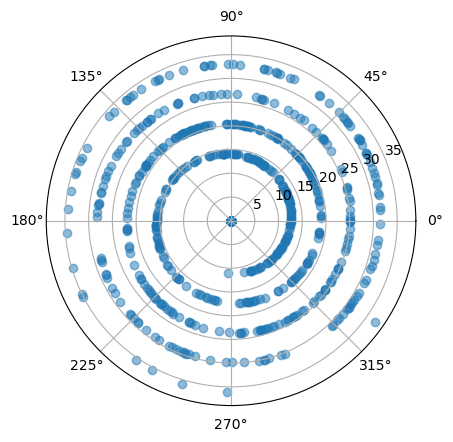

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(data['I'][image_to_plot][:][0], data['I'][image_to_plot][...][0], cmap='hsv', alpha=0.5, marker='o')

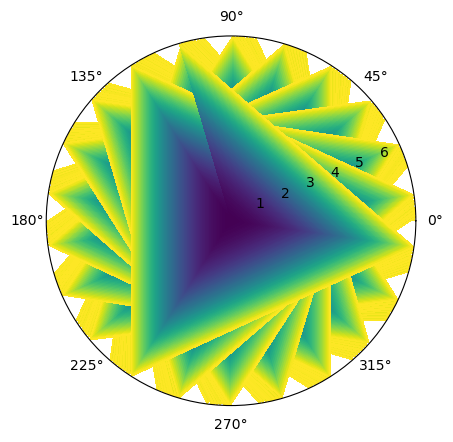

In [15]:
fig = plt.figure()
ax = Axes3D(fig)

rad = data['q']
azm = data['azi']
r, th = np.meshgrid(rad, azm)
r1 = data['I'][image_to_plot][...][:]
th1 = data['I'][image_to_plot][:][...]
z = (r ** 2.0) / 4.0

plt.subplot(projection="polar")

plt.pcolormesh(th, r, z)
#plt.pcolormesh(th, z, r)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

In [40]:
print(np.max(data['I'][image_to_plot][:][...]))
print(np.where(data['I'][image_to_plot][:] > 50))
print(np.delete(data['I'][image_to_plot], np.array([[62, 449], [155, 1303], [155, 1304]]), 1).shape)

401.35938
(array([ 62, 115, 115]), array([ 449, 1303, 1304]))
(180, 1995)


Now with this data we can visualize the snake scan. If we take all images and rearrange them into a $61 \times 50$ matrix we have the full rectangular image with all scans ordered as they were taken.

In [5]:
""" Reshape the intensity function to have its first two coordinate being the row and the column
With I(img_number,azi,q) as input, the output is I(row,column,azi,q)
"""
data['I'] = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))    
#Since it is a snake scan, we need to flip every other row.
data['I'][1::2,:,:,:] = data['I'][1::2,::-1,:,:]